In [ ]:
!pip install -q -U tensorflow-text==2.7.3

     |████████████████████████████████| 4.9 MB 5.7 MB/s 
     |████████████████████████████████| 495.0 MB 26 kB/s 
     |████████████████████████████████| 1.3 MB 58.8 MB/s 
     |████████████████████████████████| 463 kB 55.7 MB/s 


In [ ]:
!pip install -q -U tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 29.3 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.7 MB/s 
     |████████████████████████████████| 90 kB 9.2 MB/s 
     |████████████████████████████████| 352 kB 56.7 MB/s 
     |████████████████████████████████| 47.7 MB 150 kB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 234 kB 45.3 MB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 


In [ ]:
!pip install -U tfds-nightly==4.3.0.dev202107180106

     |████████████████████████████████| 4.0 MB 5.3 MB/s 


In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
print(tf.__version__)

2.7.1


In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU. Will take too much time.')

Using TPU


In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [ ]:
test_preprocess_model = make_bert_preprocess_model(['input_1', 'input_2'])
test_text = [np.array(['Dr. Dhirendra Kumar Sharma is a professor at UPES']),
             np.array(['Dr. Chandan Sharma is also a professor at UPES'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2852  1012 28144  7442 17670  9600 14654  2003  1037  2934  2012
  2039  2229   102  2852], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(16,), dtype=int32)


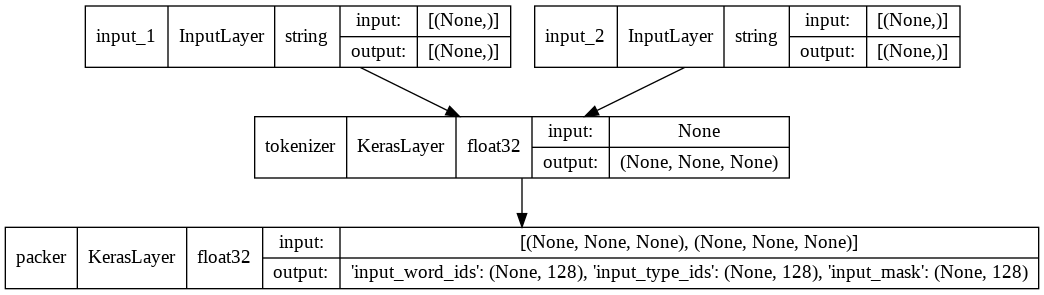

In [ ]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

## Defining the model

In [ ]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

testing the model on preprocessed inputs.

In [ ]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.62720764 0.9472531 ]], shape=(1, 2), dtype=float32)


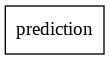

In [ ]:
tf.keras.utils.plot_model(test_classifier_model, show_shapes=True, show_dtype=True)

## Choosing a GLUE task

In [ ]:
tfds_name = 'glue/sst2'

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(10):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/sst2 from TFDS
This dataset has 70042 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/67349 [00:00<?, ? examples/s]

Shuffling glue-train.tfrecord...:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/872 [00:00<?, ? examples/s]

Shuffling glue-validation.tfrecord...:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1821 [00:00<?, ? examples/s]

Shuffling glue-test.tfrecord...:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/sst2 dataset
['negative', 'positive']

sample row 1
b'for the uninitiated plays better on video with the sound '
label: 0 (negative)

sample row 2
b'like a giant commercial for universal studios , where much of the action takes place '
label: 0 (negative)

sample row 3
b'company once again dazzle and delight us '
label: 1 (positive)

sample row 4
b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke "
label: 1 (positive)

sample row 5
b', this cross-cultural soap opera is painfully formulaic and stilted . '
label: 0 (negative)

sample row 6
b", the film is n't nearly as downbeat as it sounds , but strikes a tone that 's alternately melancholic , hopeful and strangely funny . "
label: 1 (positive)

sample row 7
b'only masochistic moviegoers need apply 

The dataset also determines the problem type (classification or regression) and the appropriate loss function for training.

In [ ]:
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#   metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metrics, loss

## Train your model

In [ ]:
epochs = 4
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  history = classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


2104/2104 [==============================] - 242s 81ms/step - loss: 0.2829 - accuracy: 0.8909 - val_loss: 0.2458 - val_accuracy: 0.9259
Epoch 2/4
2104/2104 [==============================] - 166s 79ms/step - loss: 0.1353 - accuracy: 0.9604 - val_loss: 0.2726 - val_accuracy: 0.9271
Epoch 3/4
2104/2104 [==============================] - 165s 78ms/step - loss: 0.0877 - accuracy: 0.9759 - val_loss: 0.3475 - val_accuracy: 0.9271
Epoch 4/4
2104/2104 [==============================] - 167s 79ms/step - loss: 0.0583 - accuracy: 0.9838 - val_loss: 0.3939 - val_accuracy: 0.9236


In [ ]:
test_dataset, test_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, test_split, batch_size, bert_preprocess_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
history.history

{'accuracy': [0.8909071683883667,
  0.9604175686836243,
  0.9758643507957458,
  0.983810544013977],
 'loss': [0.28287461400032043,
  0.13529178500175476,
  0.08766164630651474,
  0.05834278091788292],
 'val_accuracy': [0.9259259104728699,
  0.9270833134651184,
  0.9270833134651184,
  0.9236111044883728],
 'val_loss': [0.2457657754421234,
  0.2725977599620819,
  0.34753379225730896,
  0.39389631152153015]}

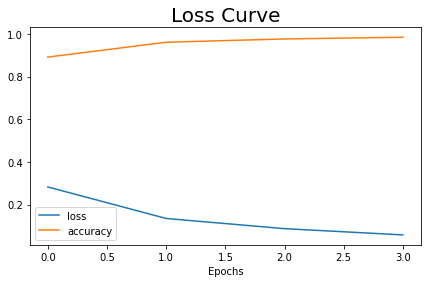

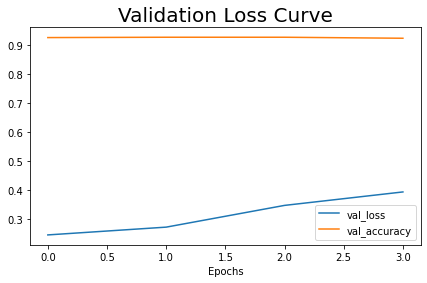

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(history.history)

# Creating a plot for loss and accuracy
plt.figure(figsize=(7,4))
plt.plot(df['loss'])
plt.plot(df['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.title("Loss Curve", fontdict={'fontsize':20})
plt.xlabel("Epochs")
plt.show();

# Creating a plot for validation loss and validation accuracy
plt.figure(figsize=(7,4))
plt.plot(df['val_loss'])
plt.plot(df['val_accuracy'])
plt.legend(['val_loss', 'val_accuracy'])
plt.title("Validation Loss Curve", fontdict={'fontsize':20})
plt.xlabel("Epochs")
plt.show();

## Export for inference


In [ ]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models/glue_sst2_bert_en_uncased_L-12_H-768_A-12


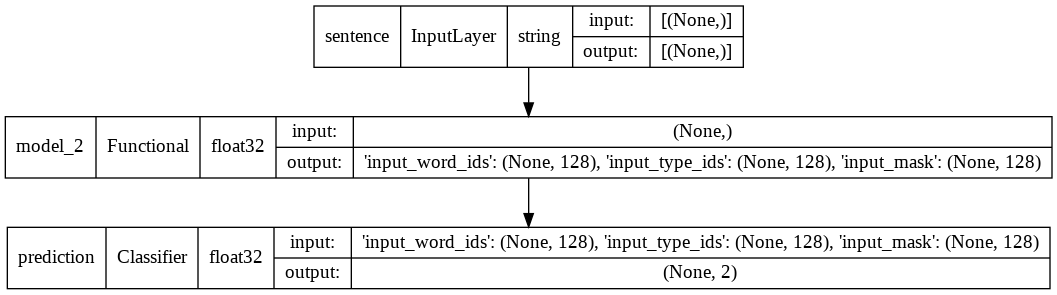

In [ ]:
tf.keras.utils.plot_model(model_for_export, show_shapes=True, show_dtype=True)

In [ ]:
classifier_model.evaluate(test_dataset)

57/57 [==============================] - 4s 28ms/step - loss: nan - accuracy: 0.0000e+00


[nan, 0.0]

In [ ]:
pred = classifier_model.predict(test_dataset)

In [ ]:
pred

array([[ 2.6243784, -3.8129916],
       [ 3.7292492, -4.38394  ],
       [ 3.4323578, -4.612618 ],
       ...,
       [ 1.5439181, -2.9487565],
       [-4.4255247,  4.909032 ],
       [ 3.3926773, -4.4760256]], dtype=float32)

## Test the model


In [ ]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# Utility methods

def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  print('sentence:', test[0].numpy())
  if bert_result_class == 1:
    print('This sentence is acceptable')
  else:
    print('This sentence is unacceptable')



  print('BERT raw results:', bert_result[0])
  print()

### Test

In [ ]:
def load_dataset_from_tfds_2(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):

  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  dataset = dataset.batch(batch_size)
  
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

v_dataset, v_data_size = load_dataset_from_tfds_2(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)

In [ ]:
v_dataset_2 = v_dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
ar = []
pr = []

with tf.device('/job:localhost'):

    test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[validation_split])
    for test_row in test_dataset:
        ar.append(test_row['label'].numpy())
        pr.append(tf.argmax(reloaded_model(tf.reshape(test_row['sentence'], (1,))), axis=1)[0].numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ar, pr)

array([[386,  42],
       [ 26, 418]])

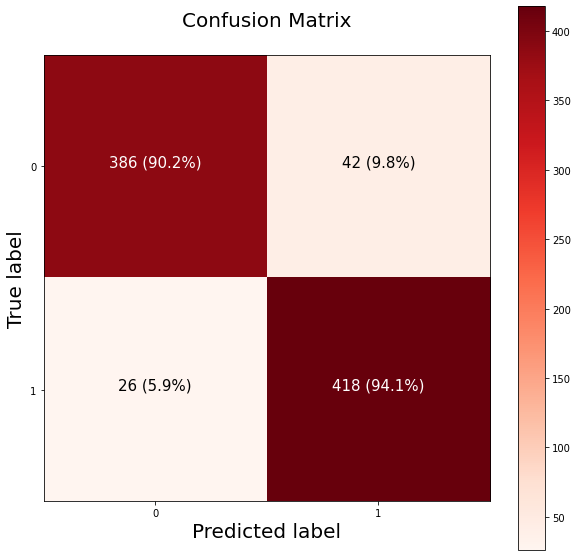

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools


figsize = (10, 10)
# Create the confusion matrix
cm = confusion_matrix(ar, pr)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Reds)
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)


In [ ]:
with tf.device('/job:localhost'):

    false_pred = []

    test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[validation_split])
    i = 0
    for test_row in test_dataset:
        if ar[i] != pr[i]:
            false_pred.append({'id': i,
                               'actual_label': ar[i],
                               'predicted_label': pr[i],
                               'sentence': test_row['sentence'].numpy()})
        i = i+1

In [ ]:
for fp in false_pred:
    if fp['actual_label']==0:
        print()
        print(fp['sentence'])


b'a synthesis of cliches and absurdities that seems positively decadent in its cinematic flash and emptiness . '

b'with its dogged hollywood naturalism and the inexorable passage of its characters toward sainthood , windtalkers is nothing but a sticky-sweet soap . '

b"although huppert 's intensity and focus has a raw exhilaration about it , the piano teacher is anything but fun . "

b'movie fans , get ready to take off ... the other direction . '

b"it 's somewhat clumsy and too lethargically paced -- but its story about a mysterious creature with psychic abilities offers a solid build-up , a terrific climax , and some nice chills along the way . "

b"moretti 's compelling anatomy of grief and the difficult process of adapting to loss . "

b'manages to show life in all of its banality when the intention is quite the opposite . '

b"it 's of the quality of a lesser harrison ford movie - six days , seven nights , maybe , or that dreadful sabrina remake . "

b'rarely has leukemia looke

On random data (without labels)

In [ ]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(10):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)

sentence: [b'the movie will reach far beyond its core demographic .']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.684583   3.3645928], shape=(2,), dtype=float32)

sentence: [b'novak manages to capture a cruelly hilarious vein of black comedy in the situation with his cast of non-actors and a gritty , no-budget approach .']
This sentence is acceptable
BERT raw results: tf.Tensor([-3.4244595  4.4776654], shape=(2,), dtype=float32)

sentence: [b'an original gem about an obsession with time .']
This sentence is acceptable
BERT raw results: tf.Tensor([-4.3335934  5.1309457], shape=(2,), dtype=float32)

sentence: [b'one of the most haunting , viciously honest coming-of-age films in recent memory .']
This sentence is acceptable
BERT raw results: tf.Tensor([-3.9465978  4.9731317], shape=(2,), dtype=float32)

sentence: [b'borrows from so many literary and cinematic sources that this future world feels absolutely deja vu .']
This sentence is acceptable
BERT raw results: tf.Tensor

In [ ]:
with tf.device('/job:localhost'):
  serving_model = reloaded_model.signatures['serving_default']
  for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(10):
    result = serving_model(**test_row)
    # The 'prediction' key is the classifier's defined model name.
    print_bert_results(list(test_row.values()), result['prediction'], tfds_name)

sentence: b'chicago is , in many ways , an admirable achievement .'
This sentence is acceptable
BERT raw results: tf.Tensor([-4.190427   4.8799434], shape=(2,), dtype=float32)

sentence: b'flat , but with a revelatory performance by michelle williams .'
This sentence is unacceptable
BERT raw results: tf.Tensor([ 1.0008185 -1.6629018], shape=(2,), dtype=float32)

sentence: b"enough similarities to gymkata and howie long 's firestorm that my fingernails instinctively crawled towards my long-suffering eyeballs ."
This sentence is unacceptable
BERT raw results: tf.Tensor([ 0.9828222 -1.2435879], shape=(2,), dtype=float32)

sentence: b'complex , affecting and uniquely almod\xc3\xb3var , the film evokes strong emotions and pushes viewers to question their deepest notions of moral right and wrong .'
This sentence is acceptable
BERT raw results: tf.Tensor([-4.389444  4.969114], shape=(2,), dtype=float32)

sentence: b'almost everything else is wan .'
This sentence is unacceptable
BERT raw resul

Saved model could be used for serving or simple inference in a process, with a simpler api with less code and easier to maintain.
